<a href="https://colab.research.google.com/github/Ken-huea/Language-processing/blob/main/LSTN(%E5%A4%89%E6%95%B0%E3%81%AE%E8%80%83%E6%85%AE%E3%81%82%E3%82%8A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTN(変数の考慮あり)

今回は過去の<font color="red">「気温」「日照時間」</font>のデータを用いて、未来の「気温」を予測してみます。

### データの読込と確認

In [6]:
# ライブラリの読み込みと各種設定
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [7]:
weather_df = pd.read_csv("/content/LSTNによる毎週の気温予測(変数の考慮無し) (2).csv", index_col='年月日', encoding="shift-jis")
#データ読み込みで年月日をindexに格納。
weather_df.head(5)

,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2010/1/1,4.8,0.0,9.2
2010/1/2,6.3,0.0,9.0
2010/1/3,5.7,0.0,6.6
2010/1/4,6.5,0.0,5.2
2010/1/5,7.3,2.5,8.1


### データ整形

In [20]:
weather_df.head(5)

,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2010/1/1,4.8,0.0,9.2
2010/1/2,6.3,0.0,9.0
2010/1/3,5.7,0.0,6.6
2010/1/4,6.5,0.0,5.2
2010/1/5,7.3,2.5,8.1


In [21]:
# 正規化（Normarization）
from sklearn.preprocessing import MinMaxScaler
scaler_x1 = MinMaxScaler()
x1 = scaler_x1.fit_transform(weather_df['平均気温(℃)'].values.reshape(weather_df['平均気温(℃)'].shape[0],1))
x1

array([[0.14457831],
       [0.18975904],
       [0.17168675],
       ...,
       [0.21084337],
       [0.20180723],
       [0.24698795]])

In [22]:
scaler_x2 = MinMaxScaler()
x2 = scaler_x2.fit_transform(weather_df['日照時間(時間)'].values.reshape(weather_df['日照時間(時間)'].shape[0],1))
x2

array([[0.67647059],
       [0.66176471],
       [0.48529412],
       ...,
       [0.61029412],
       [0.        ],
       [0.63235294]])

In [10]:
# 説明変数を格納
data_X = []
# 目的変数を格納
data_y = []
# 時数（どこまで過去のデータを考慮したいか）
p = 10
for i in range(len(weather_df)-p):
    data_X.append([x1[i:i+p].flatten(),x2[i:i+p].flatten()])
    data_y.append(x1[i+p])
    
data_X = np.array(data_X)
data_y = np.array(data_y)

### データ分割

In [11]:
# 訓練データとテストデータに分けます。
len_train = int(len(data_X)*0.7)

X_train = data_X[:len_train]
X_test = data_X[len_train:]
y_train = data_y[:len_train]
y_test = data_y[len_train:]

print(len(X_train),len(X_test))

2549 1093


気温と日照時間を用いるのでinput=2にする。

### モデル学習

In [12]:
from keras.layers import LSTM,Dense
from keras import models

In [13]:
# 時数（どこまで過去のデータを考慮したいか）
p = 10

# モデル定義
model = models.Sequential()
model.add(
    LSTM(
        100, 
        activation='tanh', 
        input_shape=(2, p)
    )
)
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 44,501
Trainable params: 44,501
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 学習設定
model.compile(
    loss='mean_squared_error', 
    optimizer='adam', 
)

In [15]:
# ハイパーパラメータ
batch_size = 128  # バッチサイズ 32,64,128,256,512 あたり
epochs = 10       # エポック数(学習の繰り返し回数)
val_split = 0.1   # 訓練データのうちx%をvalidation dataとして分割して使います。
pati_time = 10    # y回学習しても向上しない場合は学習を打ち切ります。

In [16]:
from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）

    # 構築したモデルで学習（学習データ:trainのうち、10％を検証データ:validationとして使用）
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=val_split,
                        callbacks=[
                            callbacks.EarlyStopping(monitor='val_loss',patience = pati_time),
                            callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='val_loss', save_best_only=True)
                            ]
                    )

Epoch 1/10
18/18 [==============================] - 3s 54ms/step - loss: 0.0654 - val_loss: 0.0215
Epoch 2/10
18/18 [==============================] - 0s 9ms/step - loss: 0.0253 - val_loss: 0.0265
Epoch 3/10
18/18 [==============================] - 0s 11ms/step - loss: 0.0196 - val_loss: 0.0147
Epoch 4/10
18/18 [==============================] - 0s 10ms/step - loss: 0.0142 - val_loss: 0.0108
Epoch 5/10
18/18 [==============================] - 0s 10ms/step - loss: 0.0097 - val_loss: 0.0077
Epoch 6/10
18/18 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0059
Epoch 7/10
18/18 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 8/10
18/18 [==============================] - 0s 11ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 9/10
18/18 [==============================] - 0s 11ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 10/10
18/18 [==============================] - 0s 9ms/step - loss: 0.0052 - val_loss: 0.0054


### 可視化と精度評価

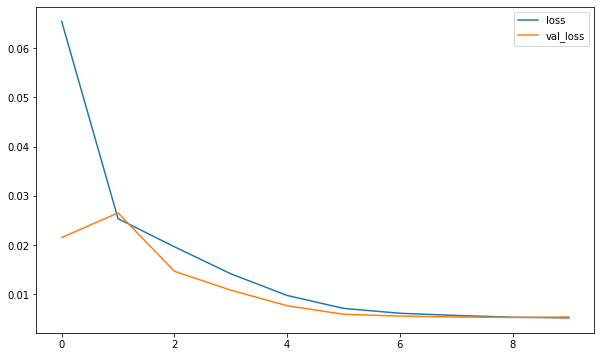

In [23]:
# loss の 学習過程のプロット

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))

plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")

plt.legend()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23455 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20104 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_te

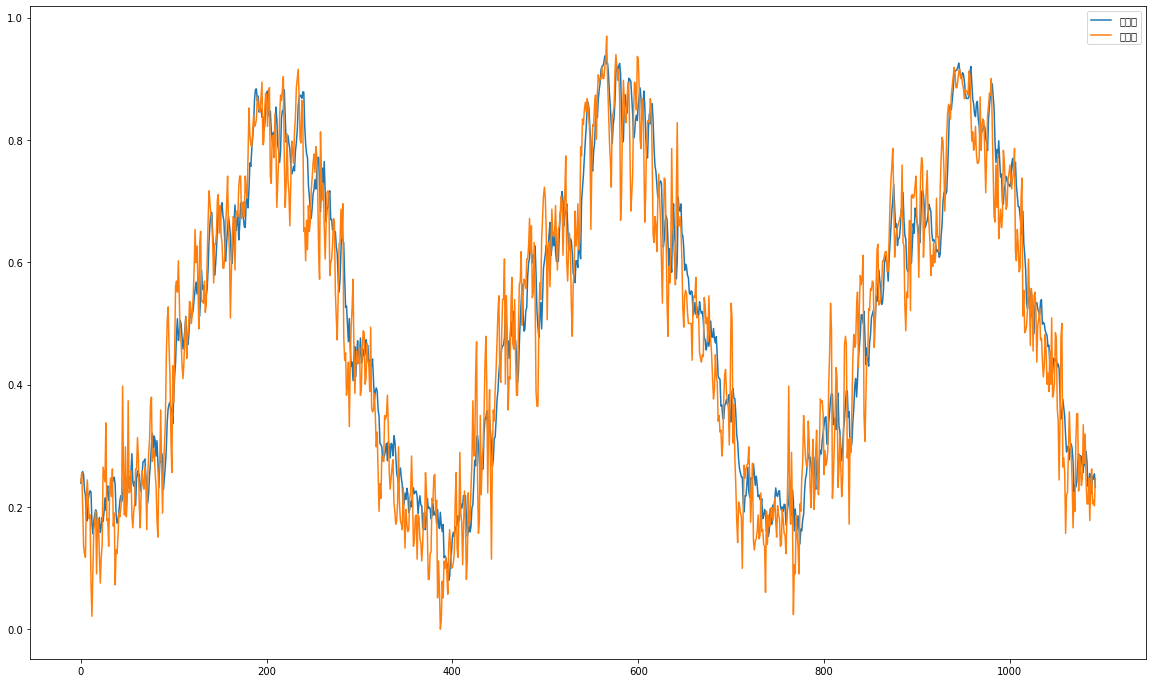

In [18]:
# 予測
fig = plt.subplots(figsize=(20,12))
y_prediction = model.predict(X_test).flatten()

plt.plot(y_prediction, label='予測値')
plt.plot(y_test, label='実測値')
plt.legend()

In [19]:
# テストデータを用いた最終的、パフォーマンス計測
score = model.evaluate(X_test, 
                            y_test,
                            verbose=0
                            )
 
# print("testデータでのloss：",score[0]) # lossの表示。
# print("testデータでのaccuracy：",score[1]) # accuracyの表示。

score

0.005218328908085823